# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [4]:
N_UNITS = 50

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [6]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [7]:
ip_reservoir.pre_train(X_TR, eta=0.0000025, epochs=10,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 2612.928466796875.
- Epoch: 2) | KL Divergence value: 2604.6025390625.
- Epoch: 3) | KL Divergence value: 2596.31103515625.
- Epoch: 4) | KL Divergence value: 2588.045166015625.
- Epoch: 5) | KL Divergence value: 2579.802978515625.
- Epoch: 6) | KL Divergence value: 2571.590576171875.
- Epoch: 7) | KL Divergence value: 2563.4130859375.
- Epoch: 8) | KL Divergence value: 2555.26318359375.
- Epoch: 9) | KL Divergence value: 2547.13916015625.
- Epoch: 10) | KL Divergence value: 2539.041015625.


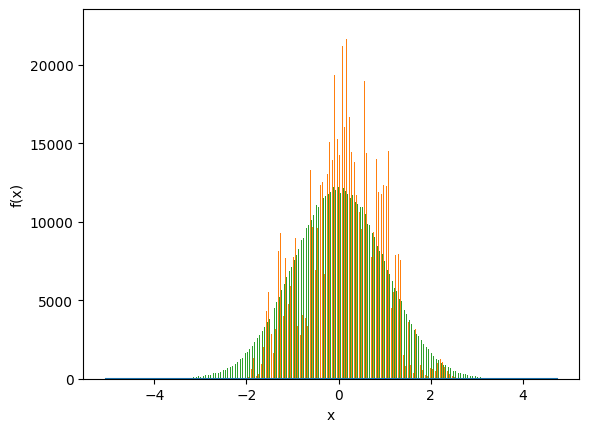

In [8]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [9]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-1.1475831270217896)  ACTUAL_STD == (0.009800293482840061)][ TARGET_MEAN == (-0.014076202176511288) TARGET_STD == (1.000584602355957)]
Unit - (2): [ ACTUAL_MEAN == (-0.08858788013458252)  ACTUAL_STD == (0.015595347620546818)][ TARGET_MEAN == (-0.010842331685125828) TARGET_STD == (1.0030484199523926)]
Overall network: [ACTUAL_MEAN == (0.12080081552267075)  ACTUAL_STD == (0.8097628355026245)]


## BIMODAL MIXTURE OF GAUSSIAN

In [10]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [11]:
bimodal_reservoir.pre_train(X_TR, eta= 0.00000025, epochs=10,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3735.13623046875.
- Epoch: 2) | KL Divergence value: 3706.712890625.
- Epoch: 3) | KL Divergence value: 3678.460693359375.
- Epoch: 4) | KL Divergence value: 3650.3837890625.
- Epoch: 5) | KL Divergence value: 3622.486328125.
- Epoch: 6) | KL Divergence value: 3594.771484375.
- Epoch: 7) | KL Divergence value: 3567.24267578125.
- Epoch: 8) | KL Divergence value: 3539.904541015625.
- Epoch: 9) | KL Divergence value: 3512.76025390625.
- Epoch: 10) | KL Divergence value: 3485.8134765625.


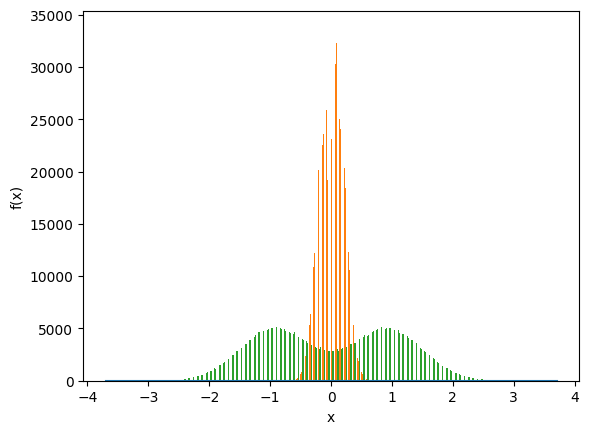

In [12]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [13]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.04029640927910805)  ACTUAL_STD == (0.00764381792396307)][ TARGET_MEAN == (-0.9137775301933289) TARGET_STD == (0.5849366784095764)]
Unit - (2): [ ACTUAL_MEAN == (0.10366999357938766)  ACTUAL_STD == (0.01266427431255579)][ TARGET_MEAN == (0.9128372073173523) TARGET_STD == (0.5827967524528503)]
Overall network: [ACTUAL_MEAN == (0.0136333629488945)  ACTUAL_STD == (0.19357039034366608)]


## EVAUALTUION IN ESN

In [14]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.train(X_TR, Y_TR, 0)
ip_esn.train(X_TR, Y_TR, 0)
bimodal_esn.train(X_TR, Y_TR, 0)


### COMPARISON ON TEST DATA

In [15]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.03273525905567933


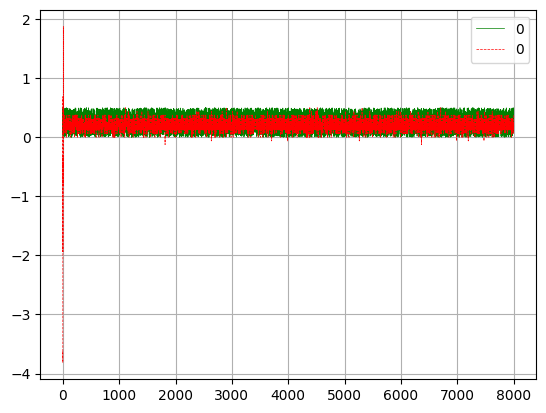

In [16]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TR, Y_TR, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.026540855504018628


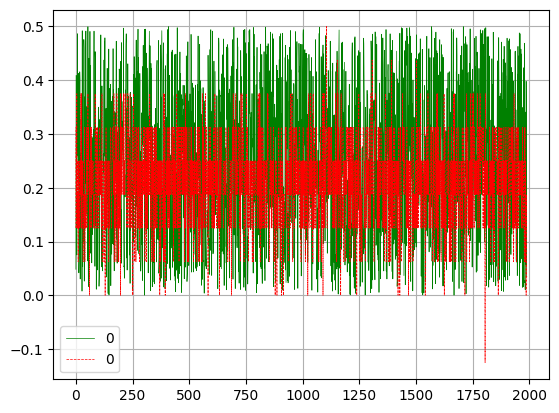

In [17]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.03628606509268266


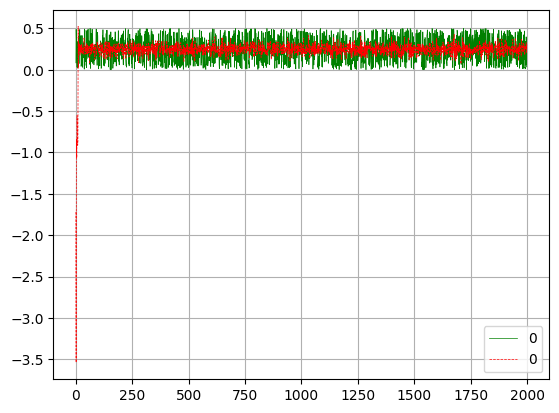

In [18]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.22027571467759963


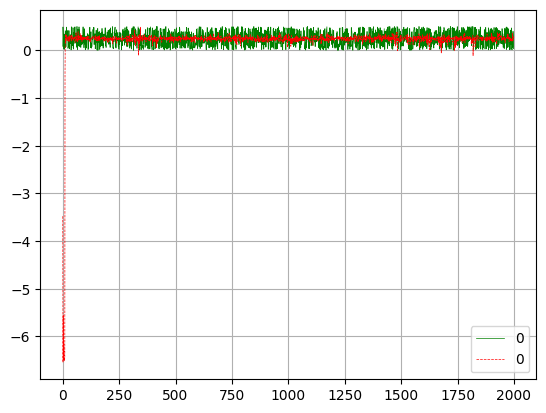

In [19]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )